# Tarea 4.

Eduardo Carrasco Vidal
Doctorado en Ingeniería de Sistemas Complejos, Universidad Adolfo Ibáñez.

Profesor: Gonzalo Ruz Heredia. Ayudante: Carlos Sepúlveda Morales.

Curso: Machine Learning (Aprendizaje Automático).

Enlace al repositorio del alumno en GitHub @educarrascov

## Instrucciones
* La tarea es individual
* Por favor responder en este mismo notebook
* Renombrar el archivo agregando su nombre, por ejemplo tarea4_Dituro_Pérez.ipynb
* Subir el archivo al link de entrega Trabajo en webcursos que será habilitado
* __Fecha de entrega:__ viernes 21 de octubre, 23:55 hrs.

In [1]:
### Conocer version de paquetes y Hardware en uso
#------------------------------------------------------
#------------------------------------------------------
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Plataforma (Software-Hardware): {platform.platform()}")
print(f"Versión de Python {sys.version}")
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"Versión de Keras: {tensorflow.keras.__version__}")
print(f"versión de Pandas {pd.__version__}")
print(f"Versión de Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU está", "Disponible" if gpu else "No Disponible")
#---------------------------------------------------------

Plataforma (Software-Hardware): macOS-13.0-arm64-i386-64bit
Versión de Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Versión de TensorFlow: 2.10.0
Versión de Keras: 2.10.0
versión de Pandas 1.5.1
Versión de Scikit-Learn 1.1.3
GPU está Disponible


## Dependencias de librerías

In [44]:
!pip install xlrd=='1.2.0'
## Despues de instalar la libreria, Reiniciar el kernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from time import time
from pandas import read_excel
import matplotlib.pyplot as plt

## Pre-processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## tensorflow-Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import metrics

## Funciones personalizadas

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    Historical performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

    @param width: width of the graphic display
    @type width: int

    @param height: height of the graphic display
    @type height: int

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

# Problema (Regresión): Aplicado al _Concrete Compressive Strength Dataset_

**Objetivo**: Predecir Concrete compressive strength (Strength)

__Descripcion__:

| **Name**             | **Data Type** | **Measurement**    | **Description** |
|----------------------|---------------|--------------------|-----------------|
| Cement | Quantitative  | kg in a m3 mixture | Input Variable  |
| Blast Furnace Slag | Quantitative | kg in a m3 mixture | Input Variable |
| Fly Ash | Quantitative | kg in a m3 mixture | Input Variable |
| Water | Quantitative | kg in a m3 mixture | Input Variable |
| Superplasticizer | Quantitative | kg in a m3 mixture | Input Variable |
| Coarse Aggregate | Quantitative | kg in a m3 mixture | Input Variable |
| Fine Aggregate | Quantitative | kg in a m3 mixture | Input Variable |
| Age | Quantitative | Day (1~365) | Input Variable |
| Concrete compressive strength | Quantitative | MPa | Output Variable |

## Carga y preprocesamiento de datos

Fuente: [Concrete Compressive Strength Data Set](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength) (UCI Repository)

In [3]:
## Load data
data = read_excel(io='https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls', 
                  sheet_name='Sheet1', header=0)

## Adding feature names
data.columns = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 
                'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength']

In [4]:
data.shape

(1030, 9)

In [5]:
data.head(4)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Con lo anterior, se verifica que todas las variables corresponden a variables numéricas

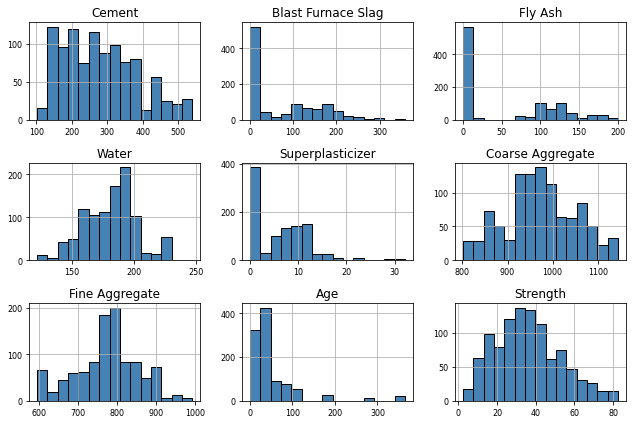

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

data.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=True)
plt.tight_layout(rect=(0, 0, 1.5, 1.5)) 

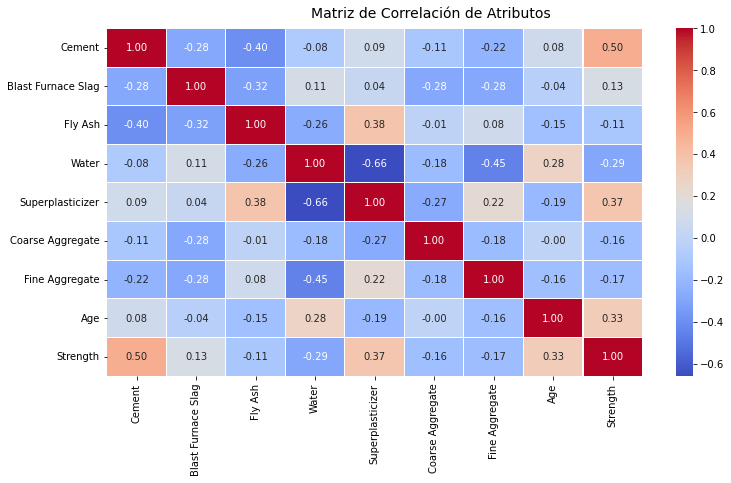

In [8]:
import seaborn as sn

f, ax = plt.subplots(figsize=(12, 6))
corr = data.corr()
hm = sn.heatmap(round(corr, 2), annot=True, ax=ax, cmap='coolwarm', fmt='.2f', linewidths=.05)

f.suptitle('Matriz de Correlación de Atributos', fontsize=14)
f.subplots_adjust(top=0.93)

Como se observa en la matriz de correlación, inicialmente se puede señalar que las variables `cement`, `Superplasticizer`, y `Age`, son las más significativas para la variable de respuesta (objetivo) `Strength`.

In [9]:
## Data partition (hold-out validation)
trainValSet, testSet = train_test_split(data, train_size=0.85, random_state=0)
trainSet, valSet = train_test_split(trainValSet, train_size=0.85, random_state=0)

## Data standardization (this function return a numpy.ndarray)
scaler = StandardScaler().fit(trainSet)
trainSet_scaled = scaler.transform(trainSet)
valSet_scaled = scaler.transform(valSet)
testSet_scaled = scaler.transform(testSet)

## Predictors and target
X_train, y_train = trainSet_scaled[:, :-1], trainSet_scaled[:, -1]
X_val,   y_val =   valSet_scaled[:, :-1], valSet_scaled[:, -1]
X_test,  y_test =  testSet_scaled[:, :-1], testSet_scaled[:, -1]

## Shape of data
print('(train shape) X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('(Validation shape) X: {}, y: {}'.format(X_val.shape, y_val.shape))
print('(test shape) X: {}, y: {}'.format(X_test.shape, y_test.shape))

(train shape) X: (743, 8), y: (743,)
(Validation shape) X: (132, 8), y: (132,)
(test shape) X: (155, 8), y: (155,)


# __Actividad__

En base a lo aprendido hoy en clase, genere un modelo predictivo mediante redes neuronales con capas Dense, para predecir el __Strength__. Utilice el conjunto de entrenamiento y validación de la mejor forma tal de poder definir los hiperparámetros de una red neuronal (número de capas ocultas, número de unidades en las capas, funciones de activación, número de épocas). Una vez que haya definido la mejor configuración de la red neuronal, entrenela (con el conjunto de entrenamiento completo, i.e., train +val) y evalúe el desempeño en el conjunto de prueba, en particular entregue el mean absolute error o el mean squared error.

### Respuesta:

## Definición de la Red Neuronal:
Inicialmente se define la red con parámetros estandar (estimados), en este caso, lo primero es definir como métrica una función de RMSE

In [10]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

 Se define una red neuronal **densa** que involucra una capa de entrada de 8 variables y una capa de salida de 1 variable correspondiente a la variable objetivo.
 En este caso, tenemos 2 capas intermedias de 32 y 16 correspondientemente.

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend
from tensorflow import keras

model = keras.Sequential([
    #Primera capa
    keras.layers.Dense(64, activation='relu', input_dim=8),
    #Segunda capa
    keras.layers.Dense(32, activation='relu'),
    #Tercera Capa
    keras.layers.Dense(16, activation='relu'),
    #Capa de salida
    keras.layers.Dense(1, activation='linear')
])

Se verifica el detalle de capas, variables y parámetros creados.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento de la red neuronal.

Objeto entrenar la red neuronal y habiendo definido el optimizador "adam", definimos el **learning rate**, el cual modificamos para obtener mejores resultados.

In [13]:
opt =keras.optimizers.Adam(learning_rate=0.00015)

Los parámetros seleccionados en esta red será autodefinidos considerando: Epocas = 20, batch_size = 12.

In [14]:
from keras import backend
model.compile(optimizer=opt, loss='mean_squared_error', metrics=[rmse])
history = model.fit(X_train, y_train, epochs = 20 , batch_size=12, validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)

print(model.summary())

Epoch 1/20
62/62 [==============================] - 1s 6ms/step - loss: 1.0241 - rmse: 0.7954 - val_loss: 0.8730 - val_rmse: 0.7679
Epoch 2/20
62/62 [==============================] - 0s 3ms/step - loss: 0.9045 - rmse: 0.7502 - val_loss: 0.7807 - val_rmse: 0.7280
Epoch 3/20
62/62 [==============================] - 0s 3ms/step - loss: 0.8165 - rmse: 0.7137 - val_loss: 0.7137 - val_rmse: 0.6932
Epoch 4/20
62/62 [==============================] - 0s 3ms/step - loss: 0.7421 - rmse: 0.6803 - val_loss: 0.6489 - val_rmse: 0.6597
Epoch 5/20
62/62 [==============================] - 0s 3ms/step - loss: 0.6695 - rmse: 0.6455 - val_loss: 0.5847 - val_rmse: 0.6272
Epoch 6/20
62/62 [==============================] - 0s 3ms/step - loss: 0.5947 - rmse: 0.6069 - val_loss: 0.5238 - val_rmse: 0.5931
Epoch 7/20
62/62 [==============================] - 0s 3ms/step - loss: 0.5229 - rmse: 0.5659 - val_loss: 0.4704 - val_rmse: 0.5565
Epoch 8/20
62/62 [==============================] - 0s 3ms/step - loss: 0.46

Posterior a esto, se identifica el indicador de R2 que simboliza qué tan cerca están los datos de la línea de regresión ajustada.

In [15]:
# Calculo de r2

y_predict = model.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test,y_predict))

5/5 [==============================] - 0s 3ms/step
0.7330271985419285


De acuerdo al resultado obtenido en r2 (73.3%), demuestra que el modelo ajusta parte de la variabilidad en torno a su media.

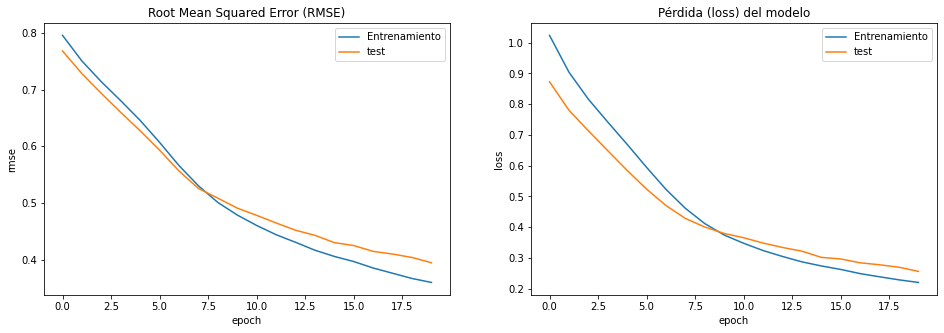

In [24]:
# Gráfico que muestra la pérdida (loss) y rmse Para Training y Test.
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'test'], loc='upper right')
# Sumatoria de pérdidas

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida (loss) del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'test'], loc='upper right')
plt.savefig('4.png')
plt.show()

Del análisis de los gráficos, en particular el 2, podemos obtener que existe una estabilización en torno a las perdidas, por lo cual, el número de épocas ideal, lo podemos relacionar a un valor cercano a 8.

## Modelo 2:

Se ejecutará una nueva simulación con variación en los hiperparámetros, considerando lo siguiente:

- Optimizador: SGD.
- Epocas : 200.
- Batch Size: 12.
- Learning Rate: 0.015.

In [46]:
from keras import backend
opt1 =keras.optimizers.SGD(learning_rate=0.015)
model.compile(optimizer=opt1, loss='mean_squared_error', metrics=[rmse])
history = model.fit(X_train, y_train, epochs = 200 , batch_size=12, validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)

print(model.summary())

Epoch 1/200
62/62 [==============================] - 1s 4ms/step - loss: 0.0701 - rmse: 0.2042 - val_loss: 0.1457 - val_rmse: 0.2986
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0852 - rmse: 0.2171 - val_loss: 0.1317 - val_rmse: 0.2859
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0785 - rmse: 0.2087 - val_loss: 0.1438 - val_rmse: 0.2865
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0671 - rmse: 0.1942 - val_loss: 0.1506 - val_rmse: 0.3057
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0749 - rmse: 0.2038 - val_loss: 0.1334 - val_rmse: 0.2860
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0684 - rmse: 0.1946 - val_loss: 0.1336 - val_rmse: 0.2824
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0667 - rmse: 0.1953 - val_loss: 0.1432 - val_rmse: 0.2818
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - lo

De igual manera, se efectúa el cálculo del r2.

In [47]:
# Calculo de r2

y_predict = model.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test,y_predict))

5/5 [==============================] - 0s 2ms/step
0.8889225035293373


De acuerdo a lo obtenido en r2, el modelo demuestra un aumento en esta métrica cercano al 88.9%

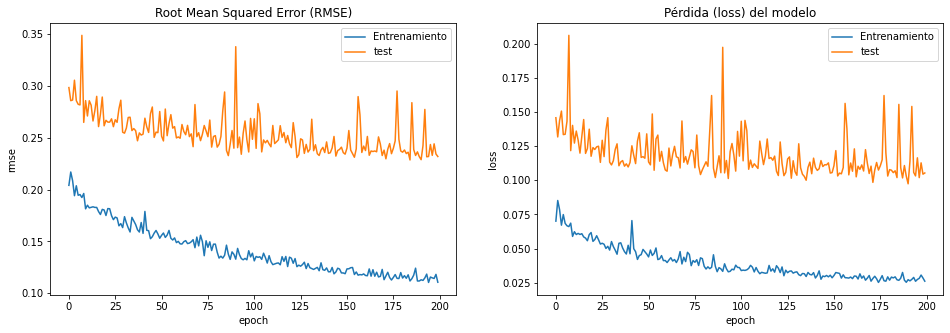

In [48]:
# Gráfico que muestra la pérdida (loss) y rmse Para Training y Test.
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'test'], loc='upper right')
# Sumatoria de pérdidas

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida (loss) del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'test'], loc='upper right')
plt.savefig('4.png')
plt.show()

Como se observa, a pesar de que presumiblemente el r2 permite explicar de mejor manera la varabiabilidad en torno a la media, no se produce convergencia en las pérdidas entre el conjunto de entrenamiento y test.

Objeto determinar parte de los hiperparámetros, se puede utilizar la función Early Stopping, objeto determinar las pérdidas globales de la funciñon monitor (val_loss, en este caso).

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
import tensorflow as tf
estop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[rmse])

history = model.fit(
    X_train, y_train,
    epochs = 10,
    steps_per_epoch=200,
    batch_size=6,
    validation_data=(X_val, y_val),
    validation_steps = 3,
    callbacks=[estop]
    )

Epoch 1/10
200/200 [==============================] - 1s 2ms/step - loss: 0.0277 - rmse: 0.1171 - val_loss: 0.1319 - val_rmse: 0.2684
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0282 - rmse: 0.1146 - val_loss: 0.1368 - val_rmse: 0.2679
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0304 - rmse: 0.1190 - val_loss: 0.1212 - val_rmse: 0.2569
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0294 - rmse: 0.1164 - val_loss: 0.1325 - val_rmse: 0.2621
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0254 - rmse: 0.1118 - val_loss: 0.1228 - val_rmse: 0.2731
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0299 - rmse: 0.1172 - val_loss: 0.1731 - val_rmse: 0.3289


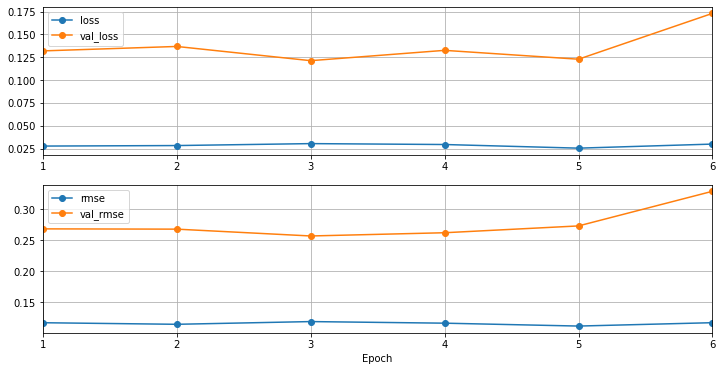

In [61]:
plot_history(history)

Se efectuará una nueva modelación con un número de épocas igual a 5, de acuerdo al resultado obtenido.

In [62]:
from keras import backend
opt2 =keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt2, loss='mean_squared_error', metrics=[rmse])
history = model.fit(X_train, y_train, epochs = 5 , batch_size=12, validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)

print(model.summary())

Epoch 1/5
62/62 [==============================] - 1s 5ms/step - loss: 0.0214 - rmse: 0.0997 - val_loss: 0.1014 - val_rmse: 0.2300
Epoch 2/5
62/62 [==============================] - 0s 3ms/step - loss: 0.0203 - rmse: 0.0967 - val_loss: 0.0990 - val_rmse: 0.2279
Epoch 3/5
62/62 [==============================] - 0s 3ms/step - loss: 0.0201 - rmse: 0.0939 - val_loss: 0.0956 - val_rmse: 0.2207
Epoch 4/5
62/62 [==============================] - 0s 3ms/step - loss: 0.0195 - rmse: 0.0955 - val_loss: 0.1003 - val_rmse: 0.2267
Epoch 5/5
5/5 [==============================] - 0s 3ms/step - loss: 0.0949 - rmse: 0.2140
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                   

In [63]:
# Calculo de r2

y_predict = model.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test,y_predict))

5/5 [==============================] - 0s 3ms/step
0.8998555802338938


Nuevamente hay un aumento en comparación con los modelos obtenidos anteriormente del resultado del r2.

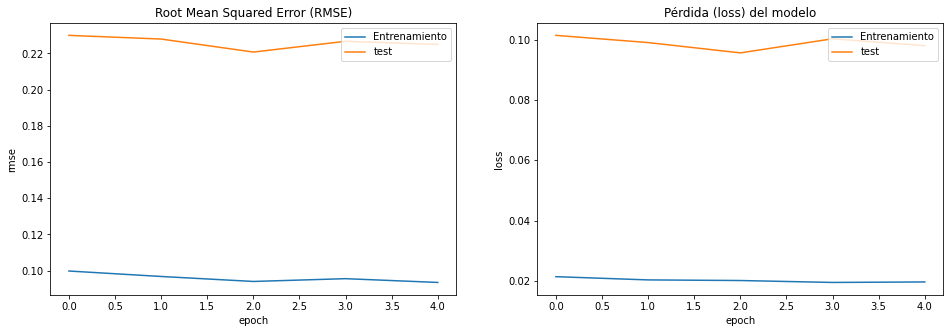

In [65]:
# Gráfico que muestra la pérdida (loss) y rmse Para Training y Test.
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'test'], loc='upper right')
# Sumatoria de pérdidas

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida (loss) del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'test'], loc='upper right')
plt.savefig('4.png')
plt.show()